In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.batches as batches
from lsst.sims.maf.runComparison import RunComparison

/epyc/projects/sssc/sources/sims_maf/python/lsst/sims/maf/runComparison/runComparison.py:23: UserWarning: 
The generateDiffHtml method requires bokeh to be installed
but it is not needed to use the other methods in this class.
Run: pip install bokeh then restart your jupyter notebook kernel.
  'but it is not needed to use the other methods in this class.'+'\n'+


In [3]:
def read_all_metricdata(workDir, metadata):
    # Just read in ALL metrics in the (joint or single) directory, 
    # Note that this will be REALLY SLOW if you give it many directories.
    if metadata is None:
        matchstring = os.path.join(workDir, '*MOOB.npz')
    else:
        matchstring = os.path.join(workDir, f'*{metadata}*MOOB.npz')
    metricfiles = glob.glob(matchstring)
    metricNames = []
    for m in metricfiles:
        mname = os.path.split(m)[-1].replace('_MOOB.npz', '')
        metricNames.append(mname)

    bdict = {}
    for mName, mFile in zip(metricNames, metricfiles):
        bdict[mName] = mmb.createEmptyMoMetricBundle()
        bdict[mName].read(mFile)

    first = bdict[metricNames[0]]
    figroot = f'{first.runName}'
    if metadata is not '.':
        figroot += f'_{metadata}'
    return figroot, bdict

def read_metricdata(workDir, metricName, verbose=True):
    # Just read a specific metric output which matches the pattern of metricName
    matchstring = os.path.join(workDir, f'*{metricName}*MOOB.npz')
    metricfiles = glob.glob(matchstring)
    if len(metricfiles) > 1:
        if verbose:
            print(f'Something is maybe wrong - found {len(metricfiles)} files matching {metricName} in {workDir}')
        return
    if len(metricfiles) == 0:
        if verbose:
            print(f'Something is maybe wrong - found no metricfiles matching {metricName} in {workDir}')
        return
    bundle = mmb.createEmptyMoMetricBundle()
    bundle.read(metricfiles[0])
    return bundle

In [4]:
def norm_df(df, norm_run,
            invert_cols=None, reverse_cols=None, mag_cols=None):
    """
    Normalize values in a dataframe to a given column
    """
    out_df = df.copy()
    if reverse_cols is not None:
        out_df[reverse_cols] = -out_df[reverse_cols]
    if invert_cols is not None:
        out_df[invert_cols] = 1/out_df[invert_cols]
    if mag_cols is not None:
        out_df[mag_cols] = 1 + out_df[mag_cols] - out_df[mag_cols].loc[norm_run]
    else:
        mag_cols = []
    cols = [c for c in df.columns.values if c not in mag_cols]
    out_df[cols] = 1 + (out_df[cols] - out_df[cols].loc[norm_run])/out_df[cols].loc[norm_run]
    return out_df

def plot(d, normed=True, style=None, figsize=(10, 5), run_nicknames=None):
    d.plot(figsize=figsize, style=style)
    plt.legend(loc=(1.01, 0))
    if normed:
        plt.axhline(0.95, alpha=0.3, linestyle=':')
        plt.axhline(1.0, alpha=0.3, linestyle='--')
        plt.axhline(1.05, alpha=0.3, linestyle=':')
    if run_nicknames is not None:
        xnames = run_nicknames
    else:
        xnames = d.index.values
    xi = np.arange(len(xnames))
    plt.xticks(xi, xnames, rotation=90, fontsize='large')
    plt.grid('k:', alpha=0.3)
    plt.tight_layout()

In [5]:
metrics = {}
short_names = {}
styles = {}
metrics['sso'] = ['3 pairs in 15 nights detection loss PHA H=16.0',
               '3 pairs in 15 nights detection loss PHA H=22.0',
               '3 pairs in 15 nights detection loss NEO H=16.0',
               '3 pairs in 15 nights detection loss NEO H=22.0',
               '3 pairs in 15 nights detection loss MBA H=16.0',
               '3 pairs in 15 nights detection loss MBA H=21.0',
               '3 pairs in 15 nights detection loss Trojan H=14.0',
               '3 pairs in 15 nights detection loss Trojan H=18.0',
               '3 pairs in 15 nights detection loss TNO H=6.0',
               '3 pairs in 15 nights detection loss TNO H=8.0',]
short_names['sso'] = ['Completeness PHA H<16.0',
               'Completeness PHA H<22.0',
               'Completeness NEO H<16.0',
               'Completeness NEO H<22.0',
               'Completeness MBA H<16.0',
               'Completeness MBA H<21.0',
               'Completeness Trojan H<14.0',
               'Completeness Trojan H<18.0',
               'Completeness TNO H<6.0',
               'Completeness TNO H<8.0',]
styles['sso'] = ['g-','g--', 'b-', 'b--', 'y-', 'y--', 'c-', 'c--', 'r-', 'r--']

metrics['Lightcurve Inversion'] = ['FractionPop Lightcurve Inversion PHA H=16.0',
 'FractionPop Lightcurve Inversion PHA H=19.0',
 'FractionPop Lightcurve Inversion NEO H=16.0',
 'FractionPop Lightcurve Inversion NEO H=19.0',
 'FractionPop Lightcurve Inversion MBA H=16.0',
 'FractionPop Lightcurve Inversion MBA H=18.0',
 'FractionPop Lightcurve Inversion Trojan H=14.0',
 'FractionPop Lightcurve Inversion Trojan H=15.0']
short_names['Lightcurve Inversion'] = ['Fraction LC Inversion PHA H=16.0',
 'Fraction LC Inversion PHA H=19.0',
 'Fraction LC Inversion NEO H=16.0',
 'Fraction LC Inversion NEO H=19.0',
 'Fraction LC Inversion MBA H=16.0',
 'Fraction LC Inversion MBA H=18.0',
 'Fraction LC Inversion Trojan H=14.0',
 'Fraction LC Inversion Trojan H=15.0']

metrics['Fraction Pop 3 bands'] = ['FractionPop 2 of g, r or i, z or y PHA H=16.0',
                      'FractionPop 2 of g, r or i, z or y PHA H=19.0',
                      'FractionPop 2 of g, r or i, z or y NEO H=16.0',
                      'FractionPop 2 of g, r or i, z or y NEO H=19.0',
                      'FractionPop 2 of g, r or i, z or y MBA H=16.0',
                      'FractionPop 2 of g, r or i, z or y MBA H=18.0',
                      'FractionPop 2 of g, r or i, z or y Trojan H=14.0',
                      'FractionPop 2 of g, r or i, z or y Trojan H=15.0',
                      'FractionPop 3 filters TNO H=6.0',
                      'FractionPop 3 filters TNO H=7.0',]
short_names['Fraction Pop 3 bands'] = ['Fraction 3 of g and (r or i) and (z or y) PHA H=16.0',
                          'Fraction 3 of g and (r or i) and (z or y) PHA H=19.0',
                      'Fraction 3 of g and (r or i) and (z or y) NEO H=16.0',
                      'Fraction 3 of g and (r or i) and (z or y) NEO H=19.0',
                      'Fraction 3 of g and (r or i) and (z or y) MBA H=16.0',
                      'Fraction 3 of g and (r or i) and (z or y) MBA H=18.0',
                      'Fraction 3 of g and (r or i) and (z or y) Trojan H=14.0',
                      'Fraction 3 of g and (r or i) and (z or y) Trojan H=15.0',
                      'Fraction 3 filters TNO H=6.0',
                      'Fraction 3 filters TNO H=7.0',]


metrics['Fraction Pop 4 bands'] = ['FractionPop 4 of grizy PHA H=16.0',
                      'FractionPop 4 of grizy PHA H=19.0',
                      'FractionPop 4 of grizy NEO H=16.0',
                      'FractionPop 4 of grizy NEO H=19.0',
                      'FractionPop 4 of grizy MBA H=16.0',
                      'FractionPop 4 of grizy MBA H=18.0',
                      'FractionPop 4 of grizy Trojan H=14.0',
                      'FractionPop 4 of grizy Trojan H=15.0',
                      'FractionPop 4 filters TNO H=6.0',
                      'FractionPop 4 filters TNO H=7.0',]
short_names['Fraction Pop 4 bands'] = ['Fraction 4 of grizy PHA H=16.0',
                          'Fraction 4 of grizy PHA H=19.0',
                      'Fraction 4 of grizy NEO H=16.0',
                      'Fraction 4 of grizy NEO H=19.0',
                      'Fraction 4 of grizy MBA H=16.0',
                      'Fraction 4 of grizy MBA H=18.0',
                      'Fraction 4 of grizy Trojan H=14.0',
                      'Fraction 4 of grizy Trojan H=15.0',
                      'Fraction 4 filters TNO H=6.0',
                      'Fraction 4 filters TNO H=7.0',]


metrics['Fraction Pop 5 bands'] = ['FractionPop 5 of grizy PHA H=16.0',
                      'FractionPop 5 of grizy PHA H=19.0',
                      'FractionPop 5 of grizy NEO H=16.0',
                      'FractionPop 5 of grizy NEO H=19.0',
                      'FractionPop 5 of grizy MBA H=16.0',
                      'FractionPop 5 of grizy MBA H=18.0',
                      'FractionPop 5 of grizy Trojan H=14.0',
                      'FractionPop 5 of grizy Trojan H=15.0',
                      'FractionPop 5 filters TNO H=6.0',
                      'FractionPop 5 filters TNO H=7.0',]
short_names['Fraction Pop 5 bands'] = ['Fraction with grizy PHA H=16.0',
                          'Fraction with grizy PHA H=19.0',
                      'Fraction with grizy NEO H=16.0',
                      'Fraction with grizy NEO H=19.0',
                      'Fraction with grizy MBA H=16.0',
                      'Fraction with grizy MBA H=18.0',
                      'Fraction with grizy Trojan H=14.0',
                      'Fraction with grizy Trojan H=15.0',
                      'Fraction with 5 filters TNO H=6.0',
                      'Fraction with 5 filters TNO H=7.0',]

metrics['Fraction Pop 6 bands'] = ['FractionPop 6 of ugrizy PHA H=16.0',
 'FractionPop 6 of ugrizy PHA H=19.0',
 'FractionPop 6 of ugrizy NEO H=16.0',
 'FractionPop 6 of ugrizy NEO H=19.0',
 'FractionPop 6 of ugrizy MBA H=16.0',
 'FractionPop 6 of ugrizy MBA H=18.0',
 'FractionPop 6 of ugrizy Trojan H=14.0',
 'FractionPop 6 of ugrizy Trojan H=15.0',
 'FractionPop 6 filters TNO H=6.0',
 'FractionPop 6 filters TNO H=7.0']
short_names['Fraction Pop 6 bands'] = ['Fraction with ugrizy PHA H=16.0',
                          'Fraction with ugrizy PHA H=19.0',
                      'Fraction with ugrizy NEO H=16.0',
                      'Fraction with ugrizy NEO H=19.0',
                      'Fraction with ugrizy MBA H=16.0',
                      'Fraction with ugrizy MBA H=18.0',
                      'Fraction with ugrizy Trojan H=14.0',
                      'Fraction with ugrizy Trojan H=15.0',
                      'Fraction with 6 filters TNO H=6.0',
                      'Fraction with 6 filters TNO H=7.0',]
styles['ssochar'] = ['g-','g--', 'b-', 'b--', 'y-', 'y--', 'c-', 'c--', 'r-', 'r--']

outDir = 'general_comp'

In [67]:
baselinesR = {'baseline_v1.4_10yrs': '1.4',
            'baseline_v1.5_10yrs': '1.5',
            'baseline_nexp1_v1.6_10yrs': '1.6'}

families = {}
nicknames = {}
baselines = {}
baselines['1.4'] = 'baseline_v1.4_10yrs'
baselines['1.5'] = 'baseline_v1.5_10yrs'
baselines['1.6'] = 'baseline_nexp1_v1.6_10yrs'

families['visittime'] = ['baseline_v1.5_10yrs',
                         'baseline_2snaps_v1.5_10yrs',
                         'u60_v1.5_10yrs',
                         'var_expt_v1.5_10yrs']
baselines['visittime'] = 'baseline_v1.5_10yrs'


families['intranight'] = [ 'baseline_2snaps_v1.5_10yrs', 
 'baseline_v1.5_10yrs', 
 'baseline_samefilt_v1.5_10yrs',
 'third_obs_pt15v1.5_10yrs', 
 'third_obs_pt30v1.5_10yrs', 
 'third_obs_pt45v1.5_10yrs', 
 'third_obs_pt60v1.5_10yrs', 
 'third_obs_pt90v1.5_10yrs', 
 'third_obs_pt120v1.5_10yrs']
baselines['intranight'] = 'baseline_v1.5_10yrs'
nicknames['intranight'] = ['2x15s visits mixed filters', 
                           '1x30s visits mixed filters',
                          '1x30s visits same filter',
                          'third visits 15 min', 
                          'third visits 30 min',
                          'third visits 45 min',
                          'third visits 60 min',
                          'third visits 90 min',
                          'third visits 120 min']

families['footprint'] = ['filterdist_indx2_v1.5_10yrs', 
                         'baseline_v1.5_10yrs',
                         'footprint_standard_goalsv1.5_10yrs',
                         'footprint_bluer_footprintv1.5_10yrs', 
                         'footprint_no_gp_northv1.5_10yrs',
                         'footprint_gp_smoothv1.5_10yrs',
                         'footprint_add_mag_cloudsv1.5_10yrs',
                         'footprint_big_sky_dustv1.5_10yrs',
                          'footprint_big_skyv1.5_10yrs',
                         'footprint_big_sky_nouiyv1.5_10yrs',
                         'footprint_big_wfdv1.5_10yrs',
                          'footprint_newAv1.5_10yrs',
                         'footprint_newBv1.5_10yrs',
                         'bulges_bs_v1.5_10yrs',
                         'bulges_cadence_bs_v1.5_10yrs',
                         'bulges_bulge_wfd_v1.5_10yrs',
                         'bulges_cadence_bulge_wfd_v1.5_10yrs',
                         'bulges_cadence_i_heavy_v1.5_10yrs',
                         'bulges_i_heavy_v1.5_10yrs',
                        ]
baselines['footprint'] = 'baseline_v1.5_10yrs'
nicknames['footprint'] = ['no nes', 'standard baseline',
                         'standard baseline 2',
                         'bluer filters',
                         'no GP N extension',
                         'GP at WFD level',
                         'add MagClouds',
                         'big sky, dust-no GP',
                         'big sky - no GP',
                         'big sky - no GP, no uiy',
                         'big WFD',
                         'big sky + GP1 + NES',
                         'big sky + GP2 + NES',
                         'big sky + GP3',
                         'big sky + GP bulge',
                         'big sky + GP bulge cadenced',
                         'big sky + GP bulge i heavy',
                         'big sky + GP i heavy']

families['filterdist'] =  ['filterdist_indx1_v1.5_10yrs',
     'filterdist_indx2_v1.5_10yrs',
     'filterdist_indx3_v1.5_10yrs',
     'filterdist_indx4_v1.5_10yrs',
     'filterdist_indx5_v1.5_10yrs',
     'filterdist_indx6_v1.5_10yrs',
     'filterdist_indx7_v1.5_10yrs',
     'filterdist_indx8_v1.5_10yrs',]
baselines['filterdist'] = 'filterdist_indx2_v1.5_10yrs'

families['filterspacing'] = ['even_filters_alt_g_v1.6_10yrs',
                            'even_filters_altv1.6_10yrs',
                            'even_filters_g_v1.6_10yrs',
                            'even_filtersv1.6_10yrs',
                            'baseline_nexp1_v1.6_10yrs'
                           ]
baselines['filterspacing'] = 'baseline_nexp1_v1.6_10yrs'

families['rolling'] = ['rolling_fpo_2nslice0.8_v1.6_10yrs',
 'rolling_fpo_2nslice0.9_v1.6_10yrs',
 'rolling_fpo_2nslice1.0_v1.6_10yrs',
 'rolling_fpo_3nslice0.8_v1.6_10yrs',
 'rolling_fpo_3nslice0.9_v1.6_10yrs',
 'rolling_fpo_3nslice1.0_v1.6_10yrs',
 'rolling_fpo_6nslice0.8_v1.6_10yrs',
 'rolling_fpo_6nslice0.9_v1.6_10yrs',
 'rolling_fpo_6nslice1.0_v1.6_10yrs',
 'baseline_nexp1_v1.6_10yrs']
baselines['rolling'] = 'baseline_nexp1_v1.6_10yrs'
nicknames['rolling'] = ['2 band rolling less weight', 
                       '2 band rolling mid weight',
                       '2 band rolling more weight',
                       '3 band rolling less weight',
                       '3 band rolling mid weight',
                       '3 band rolling more weight',
                       '6 band rolling less weight',
                       '6 band rolling mid weight',
                       '6 band rolling more weight',
                       'baseline, no rolling']

families['twilight'] = ['twilight_neo_mod1_v1.5_10yrs',
 'twilight_neo_mod2_v1.5_10yrs',
 'twilight_neo_mod3_v1.5_10yrs',
 'twilight_neo_mod4_v1.5_10yrs',
 'baseline_v1.5_10yrs']
baselines['twilight'] = 'baseline_v1.5_10yrs'
nicknames['twilight'] = ['every night',
                        'every other night',
                        'every third night',
                        'every fourth night',
                        'baseline']

families['upairs'] = ['uparis_illum_15_scale1v1.4_10yrs',
 'uparis_illum_15_scale2v1.4_10yrs',
 'uparis_illum_15_scale4v1.4_10yrs',
 'uparis_illum_30_scale1v1.4_10yrs',
 'uparis_illum_30_scale2v1.4_10yrs',
 'uparis_illum_30_scale4v1.4_10yrs',
 'uparis_illum_40_scale1v1.4_10yrs',
 'uparis_illum_40_scale2v1.4_10yrs',
 'uparis_illum_40_scale4v1.4_10yrs',
 'uparis_illum_60_scale1v1.4_10yrs',
 'uparis_illum_60_scale2v1.4_10yrs',
 'uparis_illum_60_scale4v1.4_10yrs',
 'baseline_v1.4_10yrs']
baselines['upairs'] = 'baseline_v1.4_10yrs'

families['wfdscale'] = ['wfd_depth_scale0.65_noddf_v1.5_10yrs',
                    'wfd_depth_scale0.70_noddf_v1.5_10yrs', 
                    'wfd_depth_scale0.75_noddf_v1.5_10yrs',
                    'wfd_depth_scale0.80_noddf_v1.5_10yrs',
                    'wfd_depth_scale0.85_noddf_v1.5_10yrs',
                    'wfd_depth_scale0.90_noddf_v1.5_10yrs',
                    'wfd_depth_scale0.95_noddf_v1.5_10yrs',
                    'wfd_depth_scale0.99_noddf_v1.5_10yrs']
baselines['wfdscale'] = 'baseline_v1.5_10yrs'

families['alt_dust'] = ['alt_dust_v1.5_10yrs', 
                        'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs', 
                        'bulges_bs_v1.5_10yrs',
                        'baseline_v1.5_10yrs']
baselines['alt_dust'] = 'bulges_bs_v1.5_10yrs'

families['minisurveys'] = ['short_exp_2ns_1expt_v1.5_10yrs',
                            'short_exp_2ns_5expt_v1.5_10yrs',
                            'short_exp_5ns_1expt_v1.5_10yrs',
                            'short_exp_5ns_5expt_v1.5_10yrs',
                           'twilight_neo_mod1_v1.5_10yrs',
                           'twilight_neo_mod2_v1.5_10yrs',
                           'twilight_neo_mod3_v1.5_10yrs',
                           'twilight_neo_mod4_v1.5_10yrs',
                            'dcr_nham1_ug_v1.5_10yrs',
                           'dcr_nham1_ugr_v1.5_10yrs',
                           'dcr_nham1_ugri_v1.5_10yrs',
                           'dcr_nham2_ug_v1.5_10yrs',
                           'dcr_nham2_ugr_v1.5_10yrs',
                           'dcr_nham2_ugri_v1.5_10yrs',
                           'baseline_v1.5_10yrs'
                          ]
baselines['minisurveys'] = 'baseline_v1.5_10yrs'

families['shortexp'] = ['short_exp_2ns_1expt_v1.5_10yrs',
                        'short_exp_2ns_5expt_v1.5_10yrs',
                        'short_exp_5ns_1expt_v1.5_10yrs',
                        'short_exp_5ns_5expt_v1.5_10yrs',
                       'baseline_v1.5_10yrs']
baselines['shortexp'] = 'baseline_v1.5_10yrs'

families['dcr'] = ['dcr_nham1_ug_v1.5_10yrs',
                   'dcr_nham1_ugr_v1.5_10yrs',
                   'dcr_nham1_ugri_v1.5_10yrs',
                   'dcr_nham2_ug_v1.5_10yrs',
                   'dcr_nham2_ugr_v1.5_10yrs',
                   'dcr_nham2_ugri_v1.5_10yrs',
                  'baseline_v1.5_10yrs']
baselines['dcr'] = 'baseline_v1.5_10yrs'

families['u60'] = ['u60_v1.5_10yrs',
                   'baseline_v1.5_10yrs']
baselines['u60'] = 'baseline_v1.5_10yrs'

families['var_expt'] = ['var_expt_v1.5_10yrs',
                       'baseline_v1.5_10yrs']
baselines['var_expt'] = ['baseline_v1.5_10yrs']

families['spiders'] = ['spiders_v1.5_10yrs', 'baseline_v1.5_10yrs']
baselines['spiders'] = 'baseline_v1.5_10yrs'

families['greedy'] = ['greedy_footprint_v1.5_10yrs',
                     'baseline_v1.5_10yrs']
baselines['greedy'] = 'baseline_v1.5_10yrs'

families['ddf'] = ['agnddf_v1.5_10yrs',
                  'descddf_v1.5_10yrs',
                  'daily_ddf_v1.5_10yrs',
                  'baseline_v1.5_10yrs']
baselines['ddf'] = 'baseline_v1.5_10yrs'

families['v16'] = ['barebones_nexp2_v1.6_10yrs',
                   'barebones_v1.6_10yrs',
                   'baseline_nexp2_scaleddown_v1.6_10yrs',
                   'baseline_nexp2_v1.6_10yrs',
                   'baseline_nexp1_v1.6_10yrs',
                   'combo_dust_nexp2_v1.6_10yrs',
                   'combo_dust_v1.6_10yrs',
                   'ddf_heavy_nexp2_v1.6_10yrs',
                   'ddf_heavy_v1.6_10yrs',
                   'dm_heavy_nexp2_v1.6_10yrs',
                   'dm_heavy_v1.6_10yrs',
                   'mw_heavy_nexp2_v1.6_10yrs',
                   'mw_heavy_v1.6_10yrs',
                   'rolling_exgal_mod2_dust_sdf_0.80_nexp2_v1.6_10yrs',
                   'rolling_exgal_mod2_dust_sdf_0.80_v1.6_10yrs',
                   'ss_heavy_nexp2_v1.6_10yrs',
                   'ss_heavy_v1.6_10yrs']
baselines['v16'] = 'baseline_nexp1_v1.6_10yrs'


In [6]:
objtypes = ['PHA', 'NEO', 'MBA', 'Trojan', 'TNO']
objcolors = {'PHA': 'm', 'NEO': 'r', 'MBA': 'b', 'Trojan': 'g', 'TNO': 'k'}
objorbits = {'PHA': 'granvik_pha_5k', 'NEO': 'granvik_5k', 'MBA': 'mba_5k', 'Trojan': 'trojan_5k', 'TNO': 'l7_5k'}
# pandas .plot takes a linestyle argument, so if we have bright/faint value for each population, this should work. 
linestyles = ['g-','g--', 'b-', 'b--', 'y-', 'y--', 'c-', 'c--', 'r-', 'r--']

In [8]:
# Read summary stats from csv files
big = {}
for r in ['1.4', '1.5', '1.6']:
    big[r] = pd.read_csv(os.path.join("general_comp", f"big_{r}.csv"), index_col=0)

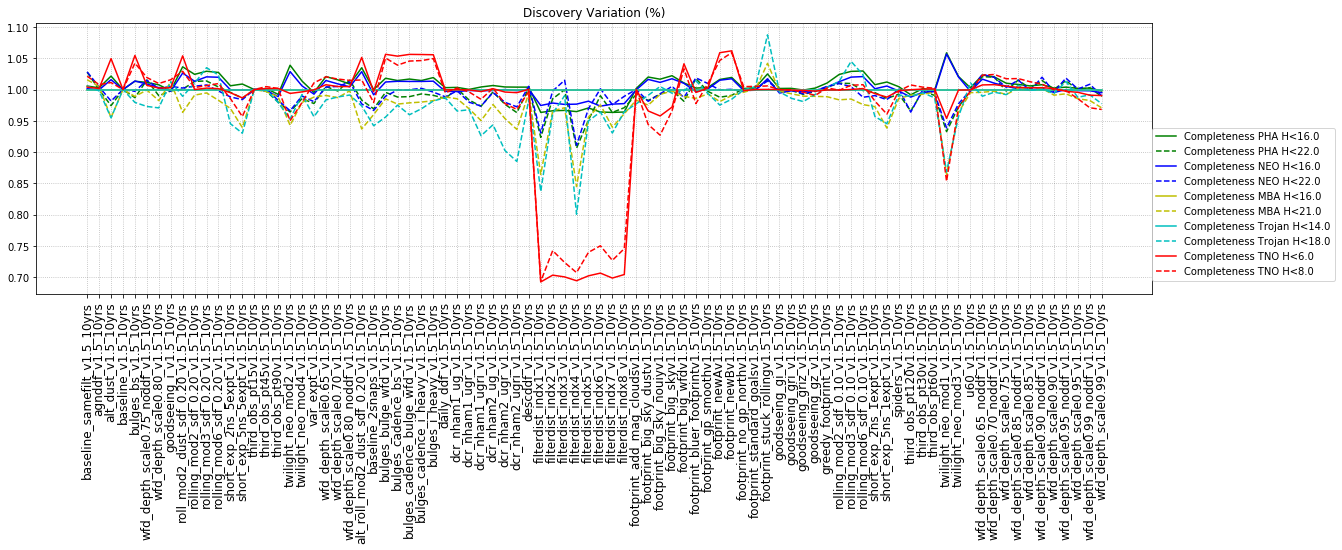

In [36]:
r = '1.5'
cols = metrics['sso']
baseline = baselines[r]
D = big[r][cols] / big[r][cols].loc[baseline] 
D.columns = short_names['sso']

xi = np.arange(len(D))
xnames = D.index.values
D.plot(figsize=(20, 5), style=styles['sso'])
plt.legend(loc=(1, 0.05))
plt.xticks(xi, xnames, rotation=90, fontsize='large')
plt.title('Discovery Variation (%)')
plt.grid(True, alpha=0.3, color='k', linestyle=':')
#plt.tight_layout()
plt.savefig(os.path.join(outDir, 'discovery_completeness_all.pdf'))

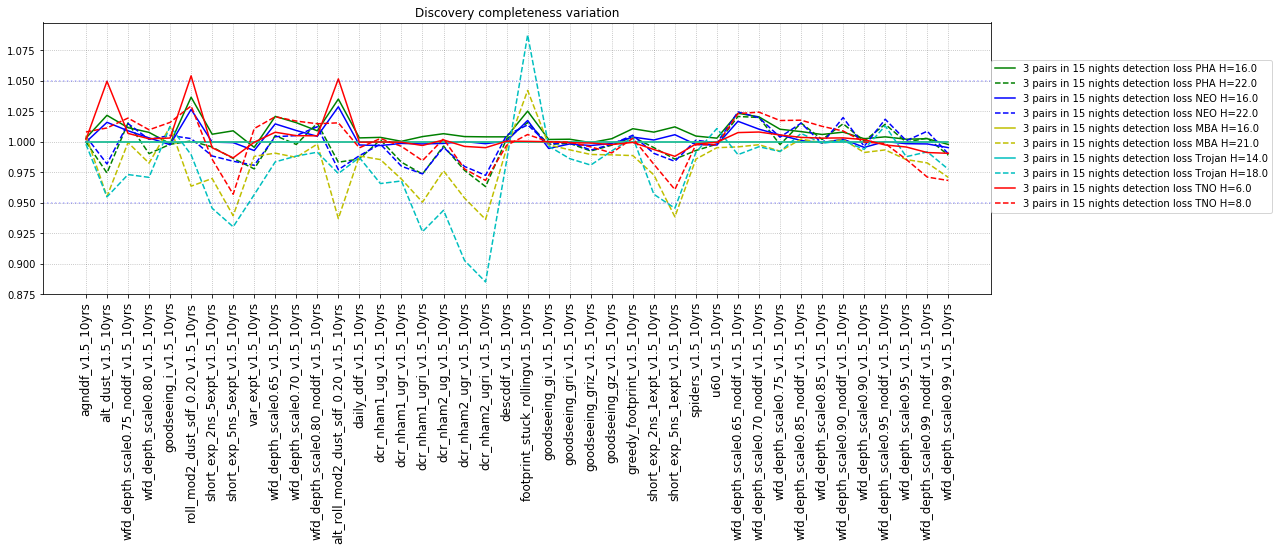

In [35]:
# And pull out the runs we look into more depth elsewhere:
twilight = ['twilight_neo_mod1_v1.5_10yrs', 'twilight_neo_mod2_v1.5_10yrs', 
            'twilight_neo_mod3_v1.5_10yrs', 'twilight_neo_mod4_v1.5_10yrs',]
rolling = ['rolling_fpo_2nslice0.8_v1.6_10yrs',
 'rolling_fpo_2nslice0.9_v1.6_10yrs',
 'rolling_fpo_2nslice1.0_v1.6_10yrs',
 'baseline_nexp1_v1.6_10yrs']
footprint = ['filterdist_indx2_v1.5_10yrs',
 'baseline_v1.5_10yrs',
 'footprint_standard_goalsv1.5_10yrs',
 'footprint_bluer_footprintv1.5_10yrs',
 'footprint_no_gp_northv1.5_10yrs',
 'footprint_gp_smoothv1.5_10yrs',
 'footprint_add_mag_cloudsv1.5_10yrs',
 'footprint_big_sky_dustv1.5_10yrs',
 'footprint_big_skyv1.5_10yrs',
 'footprint_big_sky_nouiyv1.5_10yrs',
 'footprint_big_wfdv1.5_10yrs',
 'footprint_newAv1.5_10yrs',
 'footprint_newBv1.5_10yrs',
 'bulges_bs_v1.5_10yrs',
 'bulges_cadence_bs_v1.5_10yrs',
 'bulges_bulge_wfd_v1.5_10yrs',
 'bulges_cadence_bulge_wfd_v1.5_10yrs',
 'bulges_cadence_i_heavy_v1.5_10yrs',
 'bulges_i_heavy_v1.5_10yrs']
intranight = ['nopairs_v1.4_10yrs', 
'baseline_2snaps_v1.5_10yrs', 
 'baseline_v1.5_10yrs', 
'baseline_v1.4_10yrs',
 'baseline_samefilt_v1.5_10yrs',
 'third_obs_pt15v1.5_10yrs', 
 'third_obs_pt30v1.5_10yrs', 
 'third_obs_pt45v1.5_10yrs', 
 'third_obs_pt60v1.5_10yrs', 
 'third_obs_pt90v1.5_10yrs', 
 'third_obs_pt120v1.5_10yrs']

remainder = twilight + rolling + footprint + intranight
root = '1.5'
baseline = 'baseline_v1.5_10yrs'

runs = big[root].index.values
runs = [r for r in runs if r not in remainder]
runs = [r for r in runs if not r.startswith('rolling')]
runs = [r for r in runs if not r.startswith('filterdist')]
cols = metrics['sso']
D = big[root][cols] / big[root][cols].loc[baseline] 
D = D.loc[runs]
D.plot(figsize=(17,5), style=linestyles)
plt.legend(loc=(1, .3))
xi = np.arange(len(D))
xnames = D.index.values
plt.xticks(xi, xnames, rotation=90, fontsize='large')
plt.axhline(.95, color='b', linestyle=':', alpha=0.3)
plt.axhline(1.05, color='b', linestyle=':', alpha=0.3)
plt.grid(True, alpha=0.3, linestyle=':', color='k')
plt.title(f'Discovery completeness variation')
plt.savefig(os.path.join(outDir, 'discovery_completeness_some.pdf'))

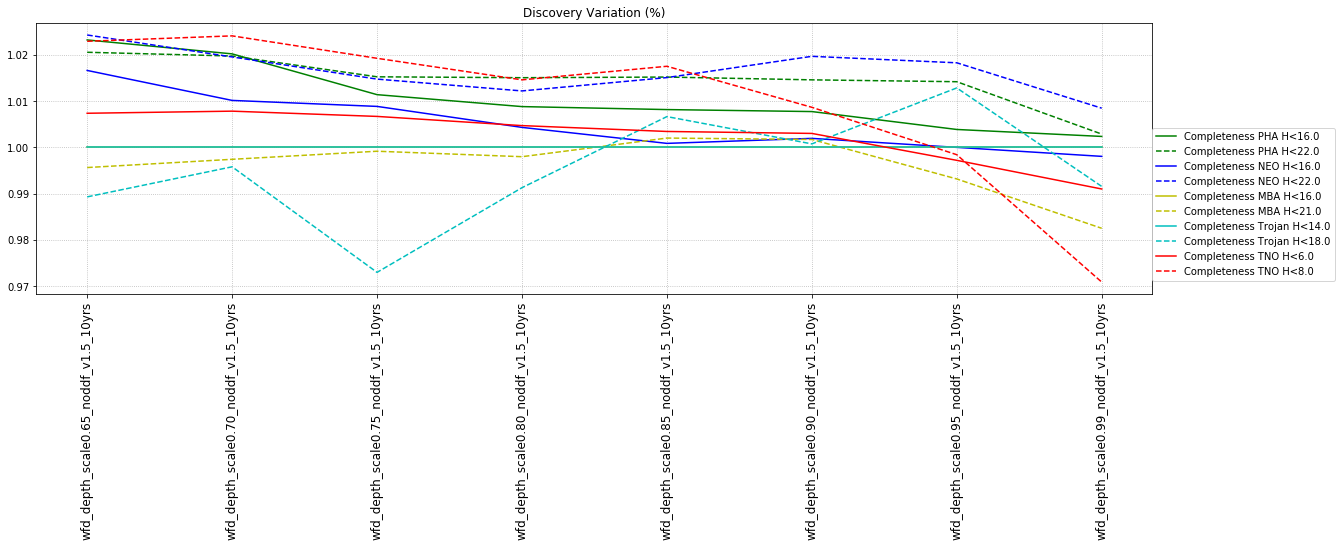

In [37]:
r = '1.5'
cols = metrics['sso']
baseline = baselines[r]
D = big[r][cols].loc[families['wfdscale']] / big[r][cols].loc[baseline] 
D.columns = short_names['sso']

xi = np.arange(len(D))
xnames = D.index.values
D.plot(figsize=(20, 5), style=styles['sso'])
plt.legend(loc=(1, 0.05))
plt.xticks(xi, xnames, rotation=90, fontsize='large')
plt.title('Discovery Variation (%)')
plt.grid(True, alpha=0.3, color='k', linestyle=':')
plt.savefig('')
#plt.tight_layout()
plt.savefig(os.path.join(outDir, 'discovery_completeness_wfdscale.pdf'))

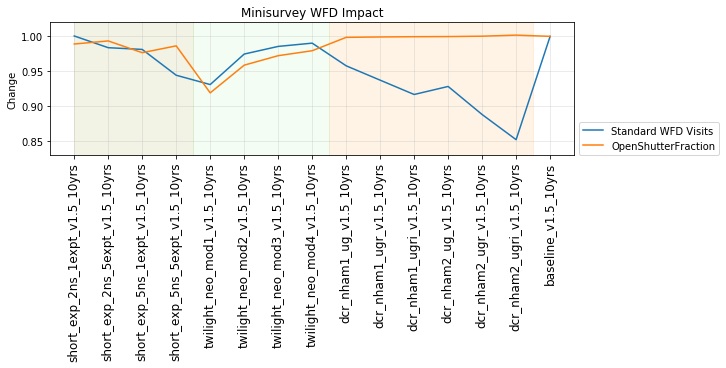

In [38]:
cols= [#'Nvisits All', 
       #'Nvisits Long Exp', 
    'Nvisits Long WFD', 
'OpenShutterFraction All visits']
d = big['1.5'][cols].loc[families['minisurveys']] / big['1.5'][cols].loc[baselines['minisurveys']]
d.columns = ['Standard WFD Visits', 'OpenShutterFraction']
plot(d, normed=False, figsize=(10, 5))
plt.ylim(0.83, 1.02)
ylims = plt.ylim()
plt.fill_between([0, 3.5], ylims[0], ylims[1], alpha=0.1, color='olive')
plt.fill_between([3.5, 7.5], ylims[0], ylims[1], alpha=0.1, color='lightgreen')
plt.fill_between([7.5, 13.5], ylims[0], ylims[1], alpha=0.1, color='darkorange')
plt.ylabel('Change')
plt.title('Minisurvey WFD Impact')
plt.savefig(os.path.join(outDir, 'minisurvey_time.pdf'))

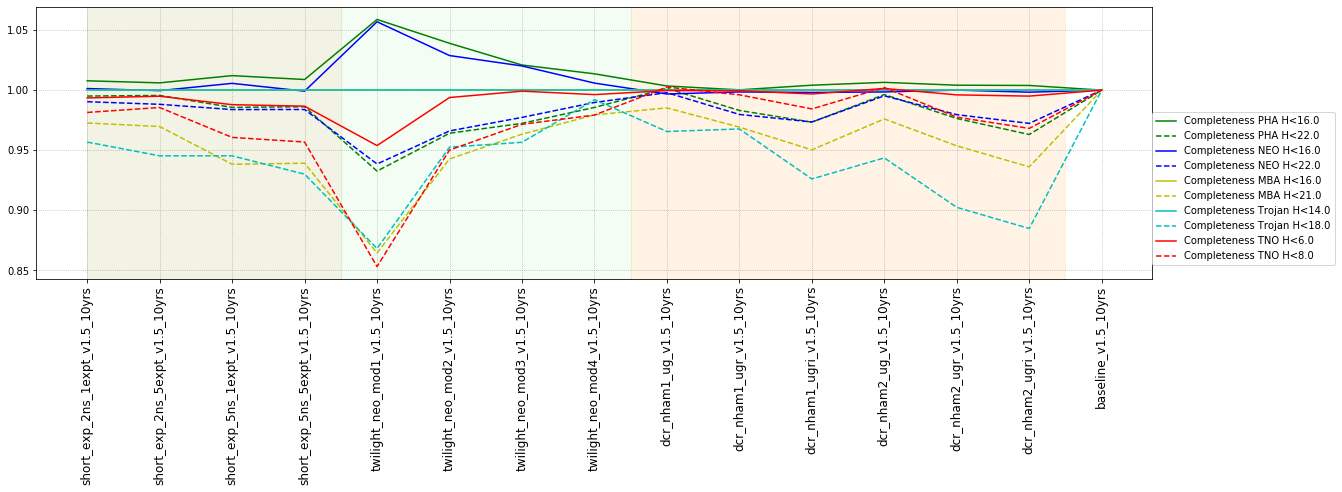

In [39]:
r = '1.5'
cols = metrics['sso']
baseline = baselines[r]
D = big[r][cols].loc[families['minisurveys']] / big[r][cols].loc[baseline] 
D.columns = short_names['sso']

xi = np.arange(len(D))
xnames = D.index.values
D.plot(figsize=(20, 5), style=styles['sso'])
plt.legend(loc=(1, 0.05))
plt.xticks(xi, xnames, rotation=90, fontsize='large')
ylims = plt.ylim()
if ylims[0] > 0.95: 
    ylim[0] = 0.95
if ylims[1] < 1.05:
    ylim[0] = 1.05
plt.ylim(ylims)
plt.fill_between([0, 3.5], ylims[0], ylims[1], alpha=0.1, color='olive')
plt.fill_between([3.5, 7.5], ylims[0], ylims[1], alpha=0.1, color='lightgreen')
plt.fill_between([7.5, 13.5], ylims[0], ylims[1], alpha=0.1, color='darkorange')
plt.grid(True, color='k', linestyle=':', alpha=0.3)
plt.savefig(os.path.join(outDir, 'discovery_completeness_minisurvey.pdf'))

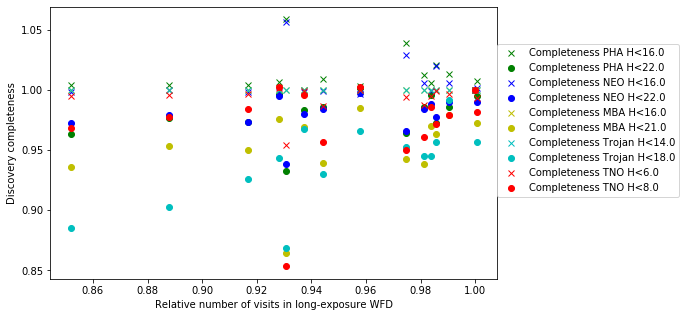

In [56]:
plt.figure(figsize=(8, 5))
for i, c in enumerate(metrics['sso']):
    if (i % 2) == 0:
        marker = 'x'
    else:
        marker = 'o'
    plt.plot(big[r]['Nvisits Long WFD'].loc[families['minisurveys']]/big[r]['Nvisits Long WFD'].loc[baseline], 
             big[r][c].loc[families['minisurveys']]/big[r][c].loc[baseline], color=styles['sso'][i][0],
            linestyle='', marker=marker, label=short_names['sso'][i])
plt.legend(loc=(1, 0.3))
plt.xlabel("Relative number of visits in long-exposure WFD")
plt.ylabel("Discovery completeness")
plt.savefig(os.path.join(outDir, 'nvisits_discovery_trend.pdf'))

/epyc/projects/sssc/conda-sssc-env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


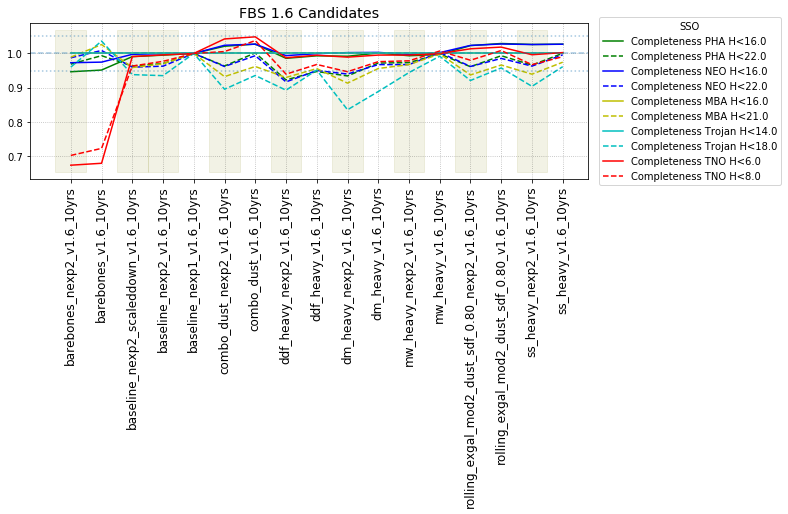

In [69]:
family = 'v16'

r = baselinesR[baselines[family]]

xnames = families[family]
nexp2 = np.zeros(len(xnames))
for i, x in enumerate(xnames):
    if 'nexp2' in x:
        nexp2[i] = 1
shadesx1 = np.where(nexp2 == 1)[0] - 0.5
shadesx2 = np.where(nexp2 == 1)[0] + 0.5

plt.figure(figsize=(10, 20))
i = 1
sharex = None

for mset in ['sso']:
    d = norm_df(big[r][metrics[mset]].loc[families[family]], baselines[family])
    d.columns = short_names[mset]
    
    ax = plt.subplot(len(metrics), 1, i, sharex=sharex)
    d.plot(ax=ax, style=styles[mset])
    plt.legend(loc='center left', bbox_to_anchor=(1.01, 0., .9, 1), fancybox=True,
               title=f'{mset.upper()}')
    plt.axhline(0.95, alpha=0.4, linestyle=':')
    plt.axhline(1.0, alpha=0.4, linestyle='--')
    plt.axhline(1.05, alpha=0.4, linestyle=':')
    ylims = plt.ylim()
    if ylims[0] > 0.95: 
        ylim[0] = 0.95
    if ylims[1] < 1.05:
        ylim[0] = 1.05
    # shade the nexp2 runs
    for x1, x2 in zip(shadesx1, shadesx2):
        plt.fill_between([x1, x2], ylims[0], ylims[1], alpha=0.1, color='olive')
    plt.grid(True, color='k', linestyle=':', alpha=0.3)
    if i == 1:
        plt.title(f'FBS {r} Candidates', fontsize='x-large')
        sharex = ax
    i += 1
xnames = d.index.values
xi = np.arange(len(xnames))
plt.xticks(xi, xnames, rotation=90, fontsize='large')
plt.tight_layout()

plt.savefig(os.path.join(outDir, 'v16_disc.pdf'))

In [65]:
d

,Completeness PHA H<16.0,Completeness PHA H<22.0,Completeness NEO H<16.0,Completeness NEO H<22.0,Completeness MBA H<16.0,Completeness MBA H<21.0,Completeness Trojan H<14.0,Completeness Trojan H<18.0,Completeness TNO H<6.0,Completeness TNO H<8.0
barebones_nexp2_v1.6_10yrs,0.946328,0.968749,0.972783,0.987259,1.0,0.989049,1.0,0.959966,0.672533,0.701170
barebones_v1.6_10yrs,0.951326,0.993442,0.974539,1.008639,1.0,1.026036,1.0,1.036218,0.678166,0.721792
baseline_nexp2_scaleddown_v1.6_10yrs,0.990656,0.963262,0.997366,0.959747,1.0,0.958580,1.0,0.937937,0.990838,0.963022
baseline_nexp2_v1.6_10yrs,0.995002,0.970377,0.999561,0.962713,1.0,0.969741,1.0,0.934907,0.995719,0.976857
baseline_nexp1_v1.6_10yrs,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000
combo_dust_nexp2_v1.6_10yrs,1.021078,0.963177,1.023924,0.961766,1.0,0.932084,1.0,0.895128,1.042485,1.005470
combo_dust_v1.6_10yrs,1.027379,1.001553,1.027217,0.993438,1.0,0.961657,1.0,0.935461,1.048633,1.037654
ddf_heavy_nexp2_v1.6_10yrs,0.985658,0.922366,0.993635,0.916581,1.0,0.929569,1.0,0.892315,0.987354,0.939306
ddf_heavy_v1.6_10yrs,0.993047,0.947071,0.999342,0.950098,1.0,0.955602,1.0,0.951344,0.994820,0.967654
dm_heavy_nexp2_v1.6_10yrs,0.991743,0.934020,1.002414,0.939643,1.0,0.912998,1.0,0.834937,0.989160,0.946442


/epyc/projects/sssc/conda-sssc-env/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


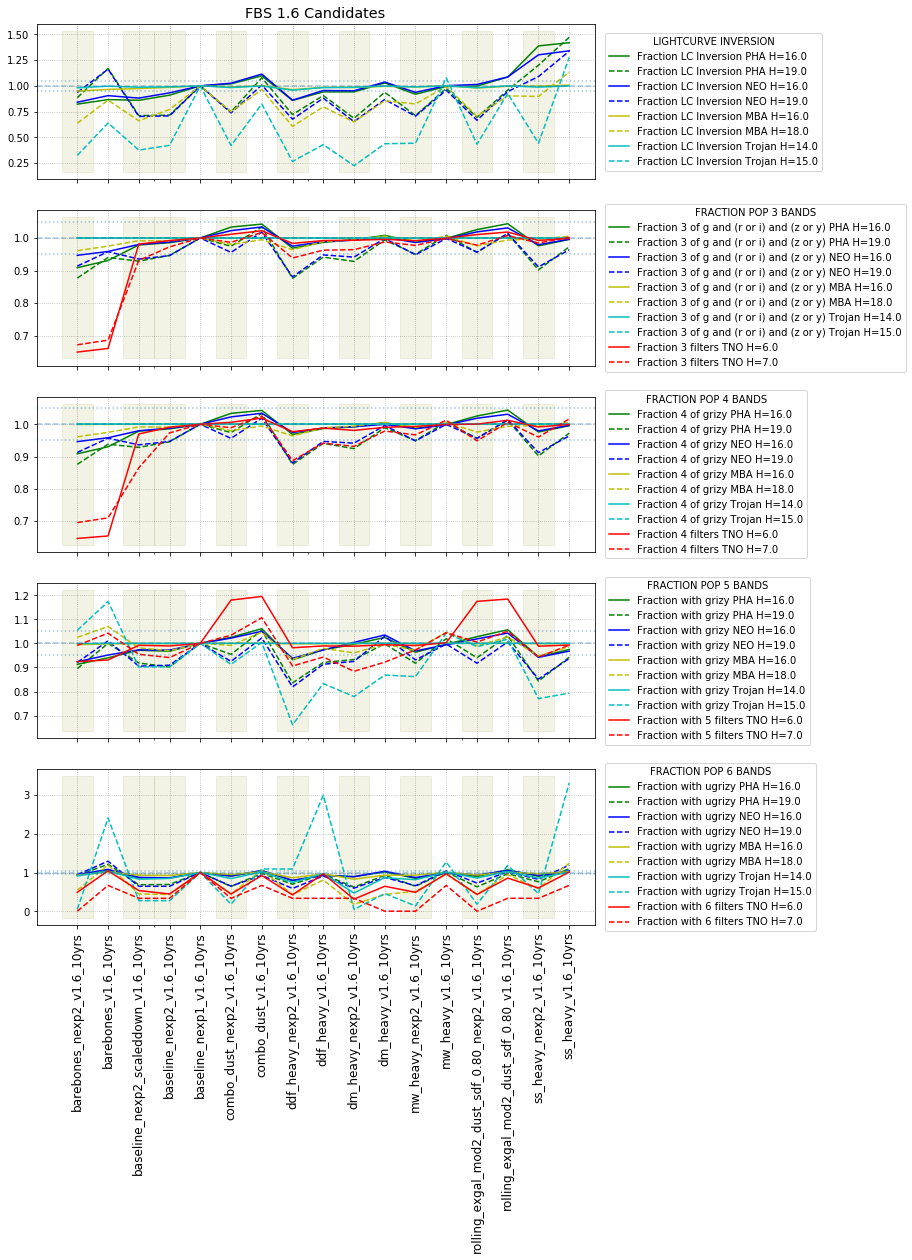

In [70]:
family = 'v16'

r = baselinesR[baselines[family]]

xnames = families[family]
nexp2 = np.zeros(len(xnames))
for i, x in enumerate(xnames):
    if 'nexp2' in x:
        nexp2[i] = 1
shadesx1 = np.where(nexp2 == 1)[0] - 0.5
shadesx2 = np.where(nexp2 == 1)[0] + 0.5

plt.figure(figsize=(10, 20))
i = 1
sharex = None

for mset in ['Lightcurve Inversion', 'Fraction Pop 3 bands', 'Fraction Pop 4 bands', 
          'Fraction Pop 5 bands', 'Fraction Pop 6 bands']:
    d = norm_df(big[r][metrics[mset]].loc[families[family]], baselines[family])
    d.columns = short_names[mset]
    
    ax = plt.subplot(len(metrics), 1, i, sharex=sharex)
    d.plot(ax=ax, style=styles['sso'])
    plt.legend(loc='center left', bbox_to_anchor=(1.01, 0., .9, 1), fancybox=True,
               title=f'{mset.upper()}')
    plt.axhline(0.95, alpha=0.4, linestyle=':')
    plt.axhline(1.0, alpha=0.4, linestyle='--')
    plt.axhline(1.05, alpha=0.4, linestyle=':')
    ylims = plt.ylim()
    if ylims[0] > 0.95: 
        ylim[0] = 0.95
    if ylims[1] < 1.05:
        ylim[0] = 1.05
    # shade the nexp2 runs
    for x1, x2 in zip(shadesx1, shadesx2):
        plt.fill_between([x1, x2], ylims[0], ylims[1], alpha=0.1, color='olive')
    plt.grid(True, color='k', linestyle=':', alpha=0.3)
    if i == 1:
        plt.title(f'FBS {r} Candidates', fontsize='x-large')
        sharex = ax
    i += 1
xnames = d.index.values
xi = np.arange(len(xnames))
plt.xticks(xi, xnames, rotation=90, fontsize='large')
plt.tight_layout()

plt.savefig(os.path.join(outDir, 'v16_char.pdf'))